In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data/speech_commands_sglr/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data/speech_commands_sglr')

  tf.io.gfile.rmtree(str(data_dir) + '/down')
  tf.io.gfile.rmtree(str(data_dir) + '/up')
  tf.io.gfile.rmtree(str(data_dir) + '/yes')
  tf.io.gfile.rmtree(str(data_dir) + '/no')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['stop' 'go' 'left' 'right']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 4000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/speech_commands_sglr/mini_speech_commands/right/ec21c46b_nohash_0.wav', shape=(), dtype=string)


In [5]:
ten_percent_length = int(filenames.shape[0] / 10)
train_files = filenames[:(filenames.shape[0] - ten_percent_length * 2)]
val_files = filenames[(filenames.shape[0] - ten_percent_length * 2):(filenames.shape[0] - ten_percent_length)]
test_files = filenames[(-ten_percent_length):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 3200
Validation set size 400
Test set size 400


In [6]:
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape
test_audio

<tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[ 0.00079346],
       [ 0.00390625],
       [ 0.0032959 ],
       ...,
       [-0.00170898],
       [ 0.00164795],
       [ 0.00085449]], dtype=float32)>

In [7]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

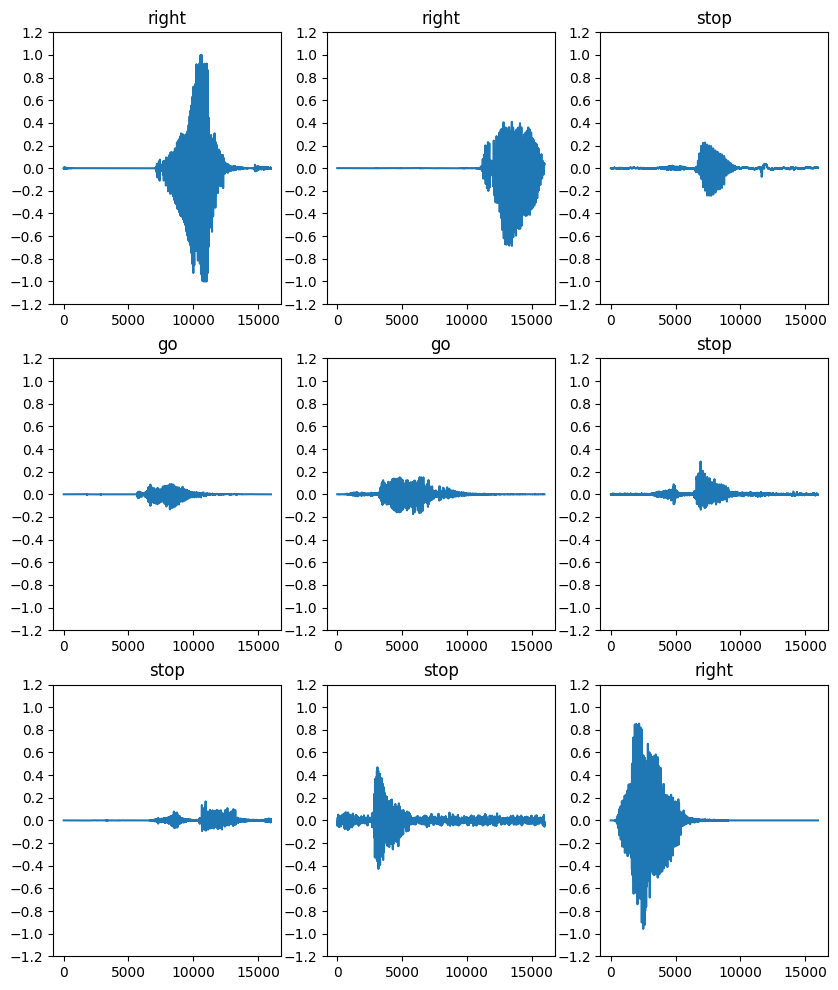

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.4, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [12]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

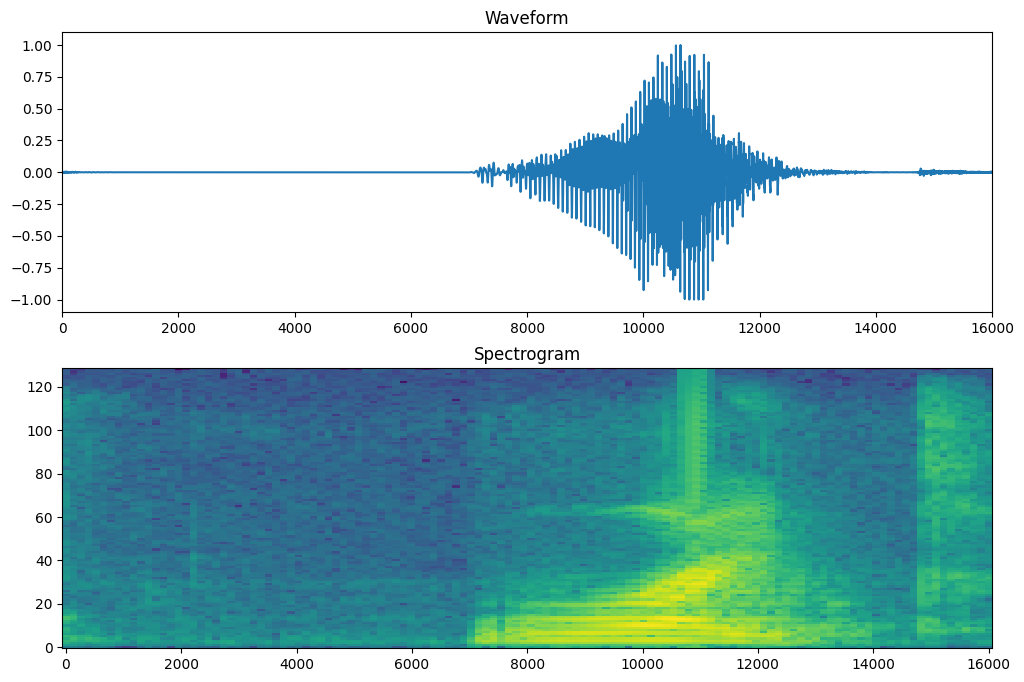

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [16]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [17]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

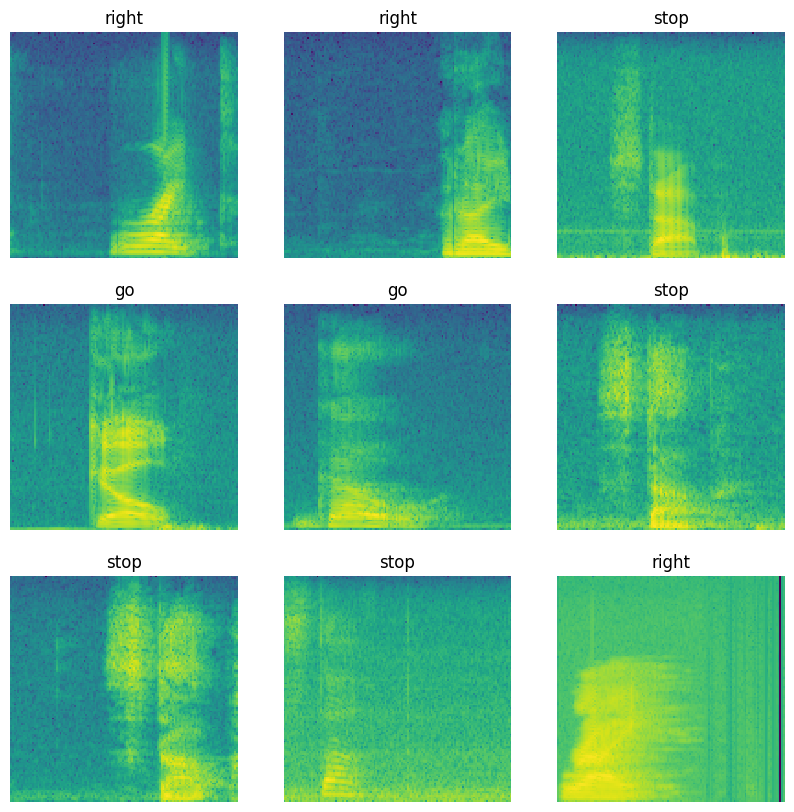

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [19]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [21]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [22]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [23]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda s, l: s))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(16, 3, activation='relu'), # added to reduce num of params
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        9232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                           

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
50/50 [==============================] - 2s 13ms/step - loss: 1.2106 - accuracy: 0.4816 - val_loss: 0.9858 - val_accuracy: 0.6725
Epoch 2/10
50/50 [==============================] - 0s 5ms/step - loss: 0.8371 - accuracy: 0.6737 - val_loss: 0.6685 - val_accuracy: 0.7600
Epoch 3/10
50/50 [==============================] - 0s 5ms/step - loss: 0.5969 - accuracy: 0.7763 - val_loss: 0.4370 - val_accuracy: 0.8600
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 0.4510 - accuracy: 0.8416 - val_loss: 0.3820 - val_accuracy: 0.8775
Epoch 5/10
50/50 [==============================] - 0s 5ms/step - loss: 0.3767 - accuracy: 0.8712 - val_loss: 0.3201 - val_accuracy: 0.9100
Epoch 6/10
50/50 [==============================] - 0s 5ms/step - loss: 0.3248 - accuracy: 0.8809 - val_loss: 0.2680 - val_accuracy: 0.9200
Epoch 7/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2434 - accuracy: 0.9128 - val_loss: 0.2046 - val_accuracy: 0.9425
Epoch 8/10
50/50 [=

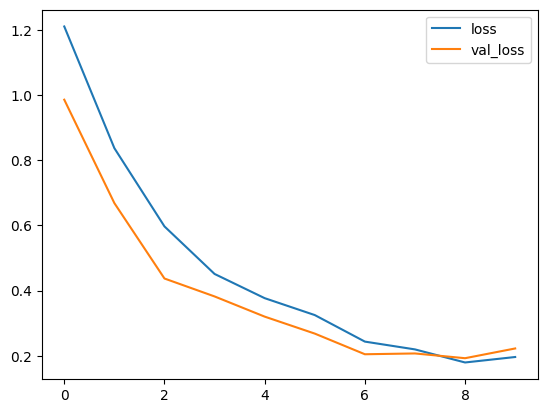

In [26]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [28]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

13/13 [==============================] - 0s 2ms/step
Test set accuracy: 93%


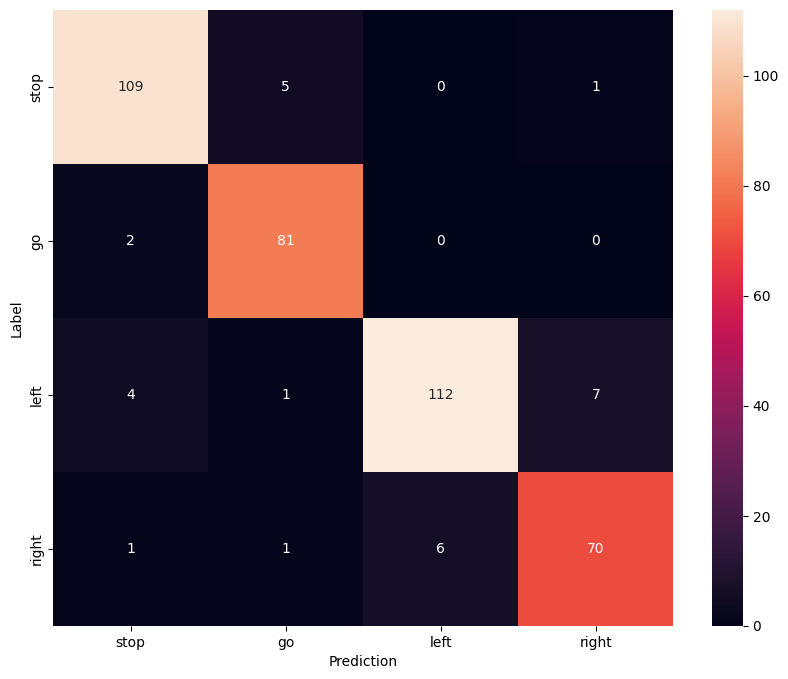

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [30]:
array_size = 8
output_file = open('speech_commands_sglr_input_10x{0}.csv'.format(array_size), 'w')

for spectrogram, label in spectrogram_ds.take(10):
  spectrogram = spectrogram[tf.newaxis, ...]
  prediction = model(spectrogram)
  print(f'Expected "{commands[label]}", inferred "{commands[tf.math.argmax(prediction[0]).numpy()]}"')

  data = spectrogram.numpy()
  for i in range(spectrogram.shape[1]):
    for j in range(spectrogram.shape[2]):
      data[0][i][j].tofile(output_file, sep=",")   
      output_file.write(",")
      np.zeros(array_size-spectrogram.shape[3], dtype='float32').tofile(output_file, sep=",")
      output_file.write("\n")

output_file.close()

Expected "right", inferred "right"
Expected "right", inferred "right"
Expected "stop", inferred "stop"
Expected "go", inferred "go"
Expected "go", inferred "go"
Expected "stop", inferred "stop"
Expected "stop", inferred "stop"
Expected "stop", inferred "stop"
Expected "right", inferred "right"
Expected "left", inferred "left"


In [31]:
model.save('speech_commands_sglr')

INFO:tensorflow:Assets written to: speech_commands_sglr/assets


INFO:tensorflow:Assets written to: speech_commands_sglr/assets


In [7]:
model = tf.keras.models.load_model('speech_commands_sglr')

In [32]:
!python -m tf2onnx.convert --saved-model speech_commands_sglr  --output speech_commands_sglr.onnx --opset 10 --inputs-as-nchw input_1:0

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-06-21 03:14:57,934 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-06-21 03:14:58,189 - INFO - Signatures found in model: [serving_default].
2022-06-21 03:14:58,189 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-06-21 03:14:58,189 - INFO - Output names: ['dense_1']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-06-21 03:14:58,258 - WARNING - From /project/.local/lib/python3.8/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-06-21 03:14:58,279 - INFO - Usin